# Is this Pokémon legendary or not?
In this notebook we will be using the full Pokémon dataset to build a model that predicts whether a Pokémon is legendary or not given its stats.

In [2]:
# Libraries for manipulating and analyzing the data
import pandas as pd
import seaborn as sns

# Libraries for Data Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset

# Libraries for building the model
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam

# Libraries for evaluating the model
from sklearn.metrics import confusion_matrix, classification_report

# Libraries for visualization
from PIL import Image

In [3]:
# Get the data
# Images: https://www.kaggle.com/datasets/arenagrenade/the-complete-pokemon-images-data-set
# Stats: https://www.kaggle.com/datasets/rounakbanik/pokemon

dataset = pd.read_csv('data/pokemon.csv')
print(dataset.shape)
dataset.head()

(801, 41)


,abilities,against_bug,against_dark,against_dragon,against_electric,against_fairy,against_fight,against_fire,against_flying,against_ghost,...,percentage_male,pokedex_number,sp_attack,sp_defense,speed,type1,type2,weight_kg,generation,is_legendary
0,"['Overgrow', 'Chlorophyll']",1.0,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,...,88.1,1,65,65,45,grass,poison,6.9,1,0
1,"['Overgrow', 'Chlorophyll']",1.0,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,...,88.1,2,80,80,60,grass,poison,13.0,1,0
2,"['Overgrow', 'Chlorophyll']",1.0,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,...,88.1,3,122,120,80,grass,poison,100.0,1,0
3,"['Blaze', 'Solar Power']",0.5,1.0,1.0,1.0,0.5,1.0,0.5,1.0,1.0,...,88.1,4,60,50,65,fire,NaN,8.5,1,0
4,"['Blaze', 'Solar Power']",0.5,1.0,1.0,1.0,0.5,1.0,0.5,1.0,1.0,...,88.1,5,80,65,80,fire,NaN,19.0,1,0


<AxesSubplot: xlabel='is_legendary', ylabel='count'>

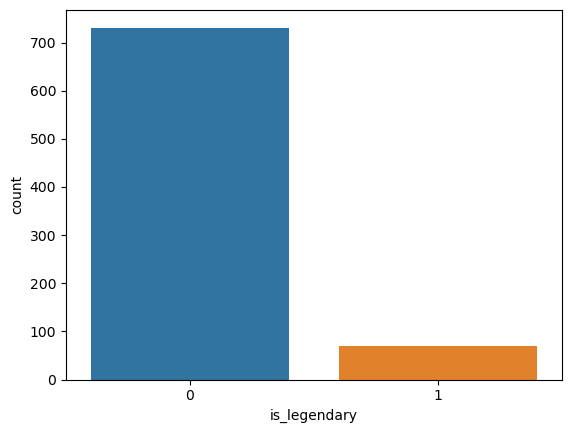

In [4]:
# How does the class label distribution look like?
sns.countplot(x='is_legendary', data=dataset)

In [5]:
# Build dataframe with only the columns where dtype is not object
dataset_cleaned = dataset.select_dtypes(exclude=['object']) # copilot suggestion.. didn't know this existed, lol
# Drop the pokedex_number and percentage_male columns
dataset_cleaned = dataset_cleaned.drop(columns=['pokedex_number', 'percentage_male'], axis=1)
# Drop the nan values
dataset_cleaned = dataset_cleaned.dropna()

print(dataset_cleaned.shape)
dataset_cleaned.head()

(781, 32)


,against_bug,against_dark,against_dragon,against_electric,against_fairy,against_fight,against_fire,against_flying,against_ghost,against_grass,...,defense,experience_growth,height_m,hp,sp_attack,sp_defense,speed,weight_kg,generation,is_legendary
0,1.0,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,0.25,...,49,1059860,0.7,45,65,65,45,6.9,1,0
1,1.0,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,0.25,...,63,1059860,1.0,60,80,80,60,13.0,1,0
2,1.0,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,0.25,...,123,1059860,2.0,80,122,120,80,100.0,1,0
3,0.5,1.0,1.0,1.0,0.5,1.0,0.5,1.0,1.0,0.50,...,43,1059860,0.6,39,60,50,65,8.5,1,0
4,0.5,1.0,1.0,1.0,0.5,1.0,0.5,1.0,1.0,0.50,...,58,1059860,1.1,58,80,65,80,19.0,1,0


<AxesSubplot: xlabel='is_legendary', ylabel='count'>

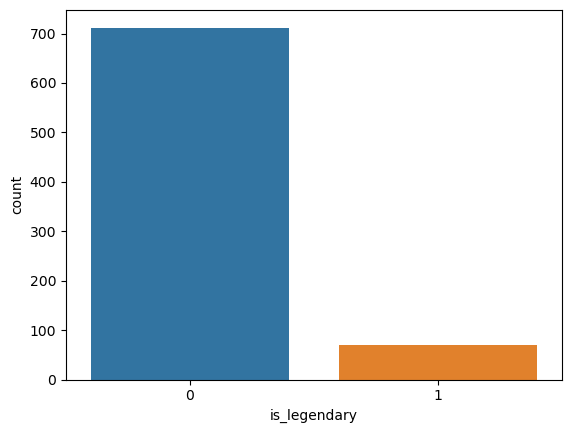

In [6]:
sns.countplot(x='is_legendary', data=dataset_cleaned) # once before droping percentage_male column and once after

In [7]:
# Split the data into input and labels
X = dataset_cleaned.iloc[:, :-1]
y = dataset_cleaned.iloc[:, -1]

In [8]:
# Split the data into train and test with 33% test size
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=60, stratify=y)
print(y_train.describe())
print(y_test.describe())

count    523.000000
mean       0.087954
std        0.283499
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: is_legendary, dtype: float64
count    258.000000
mean       0.089147
std        0.285510
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: is_legendary, dtype: float64


In [9]:
# Dataframes to numpy
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

In [10]:
# To improve the performance of the model, we standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [11]:
X_train[0], y_train[0]

(array([-0.01029525, -0.15370644,  0.02474938,  1.33910627, -0.1517854 ,
         1.24151753, -1.29369301, -1.16341546,  0.01739628,  3.8581815 ,
         1.22167461, -0.94717021, -1.42591751, -0.91992314, -0.02249268,
        -0.3804627 ,  0.04228491, -0.05707008,  1.16235305,  0.0511066 ,
         0.26674579,  0.54860589,  0.98686682, -0.30813102,  0.12032862,
        -0.36244922, -0.20297524, -0.05350361,  0.49491076, -0.2168077 ,
        -1.48495962]),
 0)

In [12]:
# Build dataset class
## train data
class TrainData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_data = TrainData(torch.FloatTensor(X_train), torch.FloatTensor(y_train))
## test data    
class TestData(Dataset):
    
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    

test_data = TestData(torch.FloatTensor(X_test))

## Let's begin with the modeling!!

In [45]:
### Hyperparameters
#   for the model itself
HIDDEN_SIZE = 64
#   for the training
EPOCHS = 20
BATCH_SIZE = 32
LEARNING_RATE = 0.001
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [46]:
# Build dataloader
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE)
test_loader = DataLoader(dataset=test_data, batch_size=1)

In [24]:
# Define model
class PokemonModel(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(PokemonModel, self).__init__()
        self.l1 = nn.Linear(input_size, hidden_size)
        self.relu1 = nn.ReLU()
        self.batchnorm1 = nn.BatchNorm1d(64)
        self.l2 = nn.Linear(hidden_size, hidden_size)
        self.relu2 = nn.ReLU()
        self.batchnorm2 = nn.BatchNorm1d(64)
        self.dropout = nn.Dropout(0.1)
        self.out = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        x = self.l1(x)
        x = self.relu1(x)
        x = self.batchnorm1(x)
        x = self.l2(x)
        x = self.relu2(x)
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.out(x)
        return x

In [47]:
# Initialize model
model = PokemonModel(input_size=X_train.shape[1], hidden_size=HIDDEN_SIZE)
model.to(device)
# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = Adam(model.parameters(), lr=LEARNING_RATE)
model

PokemonModel(
  (l1): Linear(in_features=31, out_features=64, bias=True)
  (relu1): ReLU()
  (batchnorm1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (l2): Linear(in_features=64, out_features=64, bias=True)
  (relu2): ReLU()
  (batchnorm2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (out): Linear(in_features=64, out_features=1, bias=True)
)

In [26]:
# Define the accuracy metric
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [48]:
# model.train() # Only really needed for dropout and batchnorm layers
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        
        y_pred = model(X_batch)
        
        loss = criterion(y_pred, y_batch.unsqueeze(1))
        acc = binary_acc(y_pred, y_batch.unsqueeze(1))
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        

    print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')

Epoch 001: | Loss: 0.62762 | Acc: 68.059
Epoch 002: | Loss: 0.50671 | Acc: 81.765
Epoch 003: | Loss: 0.43310 | Acc: 90.059
Epoch 004: | Loss: 0.37017 | Acc: 92.941
Epoch 005: | Loss: 0.31719 | Acc: 94.765
Epoch 006: | Loss: 0.25609 | Acc: 97.471
Epoch 007: | Loss: 0.21532 | Acc: 97.824
Epoch 008: | Loss: 0.18250 | Acc: 97.118
Epoch 009: | Loss: 0.14113 | Acc: 99.294
Epoch 010: | Loss: 0.11977 | Acc: 98.765
Epoch 011: | Loss: 0.09927 | Acc: 99.118
Epoch 012: | Loss: 0.08178 | Acc: 99.647
Epoch 013: | Loss: 0.06942 | Acc: 99.647
Epoch 014: | Loss: 0.05452 | Acc: 100.000
Epoch 015: | Loss: 0.04669 | Acc: 99.824
Epoch 016: | Loss: 0.03819 | Acc: 100.000
Epoch 017: | Loss: 0.03506 | Acc: 100.000
Epoch 018: | Loss: 0.02974 | Acc: 100.000
Epoch 019: | Loss: 0.02753 | Acc: 100.000
Epoch 020: | Loss: 0.02464 | Acc: 100.000


In [49]:
y_pred_list = []
model.eval()
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

In [50]:
confusion_matrix(y_test, y_pred_list)

array([[233,   2],
       [  3,  20]])

In [51]:
print(classification_report(y_test, y_pred_list))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       235
           1       0.91      0.87      0.89        23

    accuracy                           0.98       258
   macro avg       0.95      0.93      0.94       258
weighted avg       0.98      0.98      0.98       258



# Lets look at some specific cases

Pokemon: palkia
Legendary: 1.000


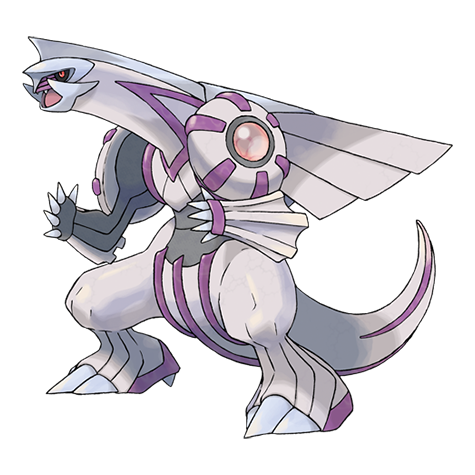

In [52]:
# Get a legendary pokemon from the dataframe
# pokemon = dataset.sample()
pokemon = dataset[dataset['is_legendary'] == 1].sample()
# Get the pokemon name
pokemon_name = pokemon['name'].values[0].lower()

# Clean example as before
pokemon = pokemon[dataset_cleaned.columns].values[0][:-1]
pokemon = scaler.transform(pokemon.reshape(1, -1))
pokemon = torch.FloatTensor(pokemon)
# Predict
model.eval()
with torch.no_grad():
    y_pred = model(pokemon.to(device))
    y_pred = torch.sigmoid(y_pred)

img = Image.open(f'data/pokemon_images/{pokemon_name}.png')
print(f'Pokemon: {pokemon_name}')
print(f'Legendary: {y_pred.item():.3f}')
img